# Задание 2. SQL
## 2.1 Очень усердные ученики.

### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

### 2.1.2 Задача

Дана таблица `default.peas`:

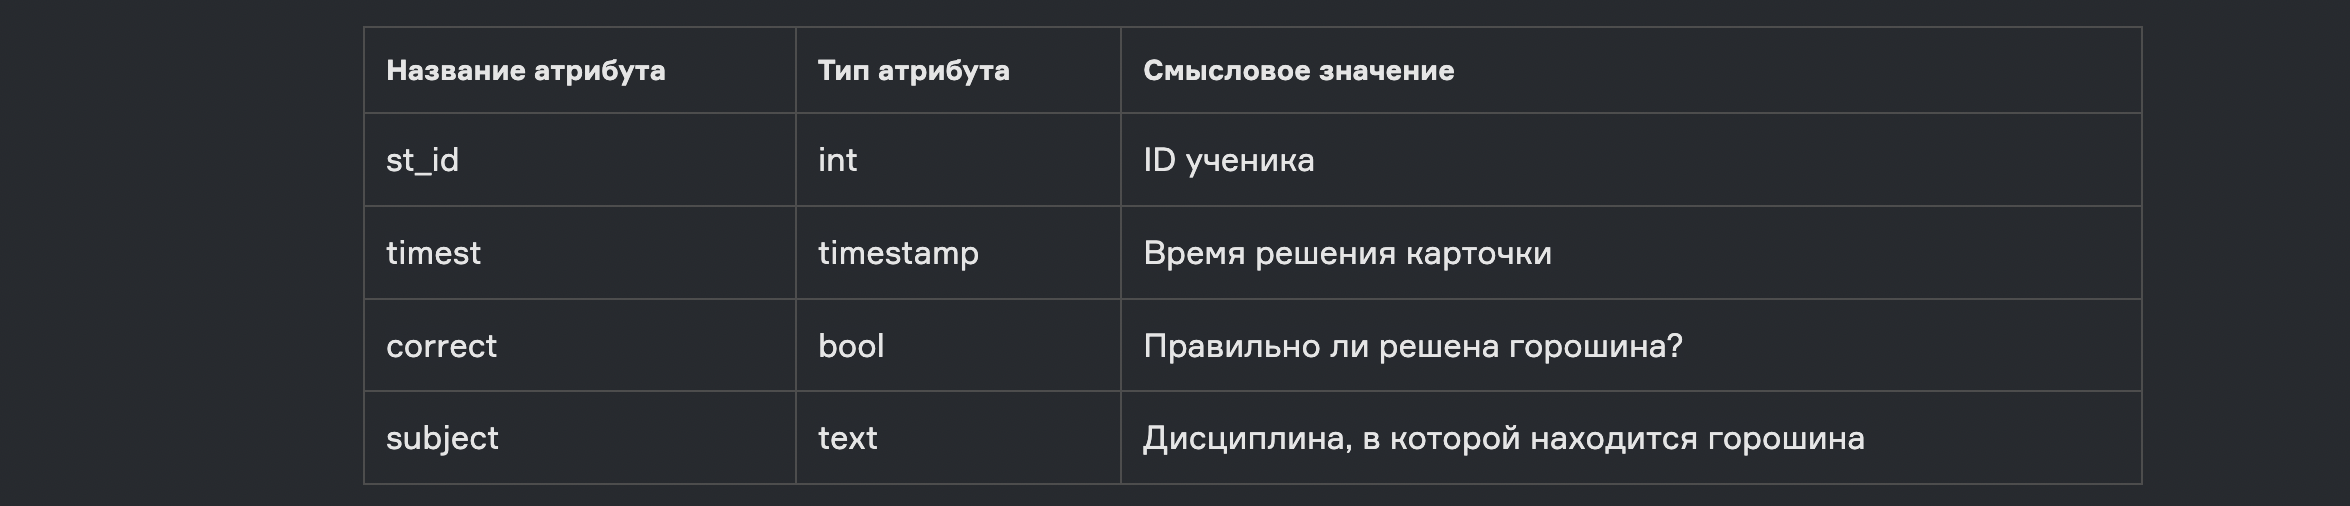

**Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.**

NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.


In [3]:
import pandahouse as ph
connection = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [4]:
query = """
SELECT
count(st_id)
FROM (
    SELECT
        st_id,
        sum(correct) as peases
    FROM default.peas 
    WHERE 
        toYear(timest) == '2020' and toMonth(timest) == '3'
    GROUP BY
        st_id
    HAVING 
        peases >= 20
    )
"""
df = ph.read_clickhouse(query, connection=connection)
df

,count(st_id)
0,0


В таблице отсутствуют данные за март 2020 года, присутствуют только за октябрь 2021
```sql
SELECT
count(st_id)
FROM (
    SELECT
        st_id,
        sum(correct) as peases
    FROM default.peas 
    WHERE 
        toYear(timest) == '2020' and toMonth(timest) == '3'
    GROUP BY
        st_id
    HAVING 
        peases >= 20
    )
```

## 2.2 Оптимизация воронки

### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели `trial`: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

### 2.2.2 Задача

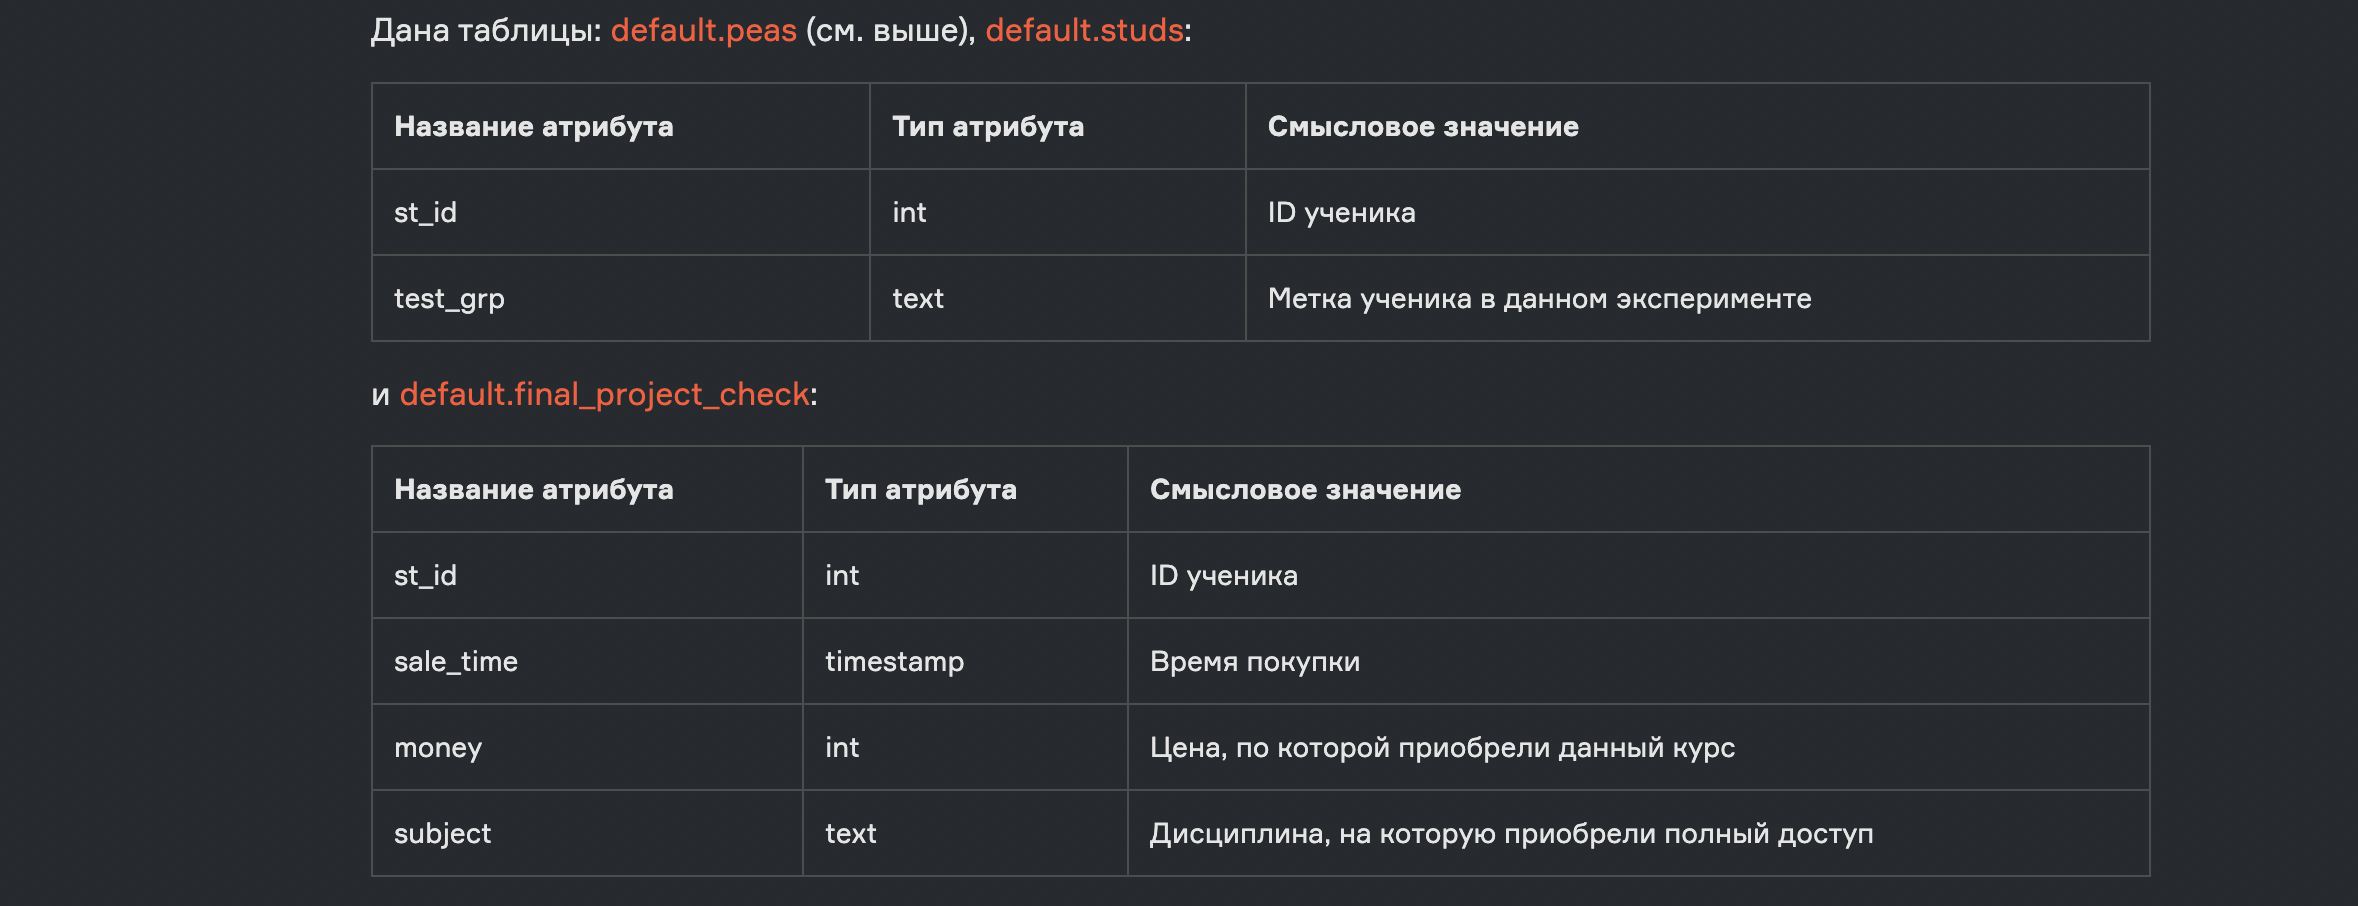

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

* ARPU 
* ARPAU 
* CR в покупку 
* CR активного пользователя в покупку 
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

### Опишем метрики
* ARPU (Average revenue per user) = весь доход / количество пользователей за период
* ARPAU (Average Revenue Per Active User) = весь доход / количество активных пользователей за период
* CR в покупку = покупки/кол-во пользователей * 100%
* CR активного пользователя в покупку = покупки/кол-во активных пользователей * 100%
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

### ARPU
*Замечание: в выборки попадут пользователи, у которых есть хотя бы одна решенная задача или оплата*

Ход решения: 
1. Объединим все три таблицы, предварительно сгруппировав их по st_id
2. Выберем только пользователей, которые проявили какую-то активность - была решенная задача или оплата, поскольку иначе такой пользователь возможно и не пользовался нашим сервисом данный период
3. Объединим по группе и вычислим ARPU

```sql
SELECT test_grp, sum(money)/COUNT(a.st_id) as ARPU
FROM 
    (
    SELECT a.st_id, peases, test_grp, money
    FROM default.studs as a 
    LEFT JOIN
        (
        SELECT
            st_id,
            sum(correct) as peases
        FROM default.peas
        GROUP BY
            st_id
        ) as b
    ON
        a.st_id = b.st_id
    LEFT JOIN
        (
        SELECT st_id, sum(money) as money
        FROM default.final_project_check
        GROUP BY st_id
        ) as c
    ON
        a.st_id = c.st_id
    WHERE peases > '0' or money > '0'
    )
GROUP BY test_grp
```

In [5]:
query = """
SELECT test_grp, sum(money)/COUNT(a.st_id) as ARPU
FROM 
    (
    SELECT a.st_id, peases, test_grp, money
    FROM default.studs as a 
    LEFT JOIN
        (
        SELECT
            st_id,
            sum(correct) as peases
        FROM default.peas
        GROUP BY
            st_id
        ) as b
    ON
        a.st_id = b.st_id
    LEFT JOIN
        (
        SELECT st_id, sum(money) as money
        FROM default.final_project_check
        GROUP BY st_id
        ) as c
    ON
        a.st_id = c.st_id
    WHERE peases > '0' or money > '0'
    )
GROUP BY test_grp
"""
df = ph.read_clickhouse(query, connection=connection)
df

,test_grp,ARPU
0,control,8496.932515
1,pilot,23576.388889


### ARPAU
*Замечание: Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.*

Ход решения: 
1. Объединим все три таблицы, предварительно сгруппировав их по st_id
2. Выберем только пользователей, которые решили больше 10 задач
3. Объединим по группе и вычислим ARPAU

```sql
SELECT test_grp, sum(money)/COUNT(a.st_id) as ARPAU
FROM 
    (
    SELECT a.st_id, peases, test_grp, money
    FROM default.studs as a 
    LEFT JOIN
        (
        SELECT
            st_id,
            sum(correct) as peases
        FROM default.peas
        GROUP BY
            st_id
        ) as b
    ON
        a.st_id = b.st_id
    LEFT JOIN
        (
        SELECT st_id, sum(money) as money
        FROM default.final_project_check
        GROUP BY st_id
        ) as c
    ON
        a.st_id = c.st_id
    WHERE peases > '10'
    )
GROUP BY test_grp
```

In [6]:
query = """
SELECT test_grp, sum(money)/COUNT(a.st_id) as ARPAU
FROM 
    (
    SELECT a.st_id, peases, test_grp, money
    FROM default.studs as a 
    LEFT JOIN
        (
        SELECT
            st_id,
            sum(correct) as peases
        FROM default.peas
        GROUP BY
            st_id
        ) as b
    ON
        a.st_id = b.st_id
    LEFT JOIN
        (
        SELECT st_id, sum(money) as money
        FROM default.final_project_check
        GROUP BY st_id
        ) as c
    ON
        a.st_id = c.st_id
    WHERE peases > '10'
    )
GROUP BY test_grp
"""
df = ph.read_clickhouse(query, connection=connection)
df

,test_grp,ARPAU
0,control,10393.700787
1,pilot,29739.583333


### CR в покупку
*Замечание: Если пользователь купил сразу несколько товаров, то будем считать это одной покупкой в рамках вычисления конверсии*

Ход решения: 
1. Объединим все три таблицы, предварительно сгруппировав их по st_id и вычислим количество пользователей
2. Объдиним таблицы studs и checks и посчитаем количество конверсий
3. Объединим таблицы из пункта 1 и 2 и вычислим конверсию

```sql
SELECT test_grp, users, conversions, (conversions/users * 100) as CR
FROM
    (
    SELECT test_grp, COUNT(a.st_id) as users
    FROM 
        (
        SELECT a.st_id, peases, test_grp, money
        FROM default.studs as a 
        LEFT JOIN
            (
            SELECT
                st_id,
                sum(correct) as peases
            FROM default.peas
            GROUP BY
                st_id
            ) as b
        ON
            a.st_id = b.st_id
        LEFT JOIN
            (
            SELECT st_id, sum(money) as money
            FROM default.final_project_check
            GROUP BY st_id
            ) as c
        ON
            a.st_id = c.st_id
        WHERE peases > '0' or money > '0'
        )
    GROUP BY test_grp
    ) as aa
LEFT JOIN
    (
    SELECT test_grp, COUNT(st_id) as conversions
    FROM
        (
        SELECT a.st_id, test_grp, money
        FROM default.studs as a 
        LEFT JOIN
            (
            SELECT st_id, sum(money) as money
            FROM default.final_project_check
            GROUP BY st_id
            ) as c
        ON
            a.st_id = c.st_id
        WHERE money > '0')
    GROUP BY test_grp
    ) as bb
ON  aa.test_grp = bb.test_grp

```

In [7]:
query = """
SELECT test_grp, users, conversions, (conversions/users * 100) as CR
FROM
    (
    SELECT test_grp, COUNT(a.st_id) as users
    FROM 
        (
        SELECT a.st_id, peases, test_grp, money
        FROM default.studs as a 
        LEFT JOIN
            (
            SELECT
                st_id,
                sum(correct) as peases
            FROM default.peas
            GROUP BY
                st_id
            ) as b
        ON
            a.st_id = b.st_id
        LEFT JOIN
            (
            SELECT st_id, sum(money) as money
            FROM default.final_project_check
            GROUP BY st_id
            ) as c
        ON
            a.st_id = c.st_id
        WHERE peases > '0' or money > '0'
        )
    GROUP BY test_grp
    ) as aa
LEFT JOIN
    (
    SELECT test_grp, COUNT(st_id) as conversions
    FROM
        (
        SELECT a.st_id, test_grp, money
        FROM default.studs as a 
        LEFT JOIN
            (
            SELECT st_id, sum(money) as money
            FROM default.final_project_check
            GROUP BY st_id
            ) as c
        ON
            a.st_id = c.st_id
        WHERE money > '0')
    GROUP BY test_grp
    ) as bb
ON  aa.test_grp = bb.test_grp
"""
df = ph.read_clickhouse(query, connection=connection)
df

,test_grp,users,conversions,CR
0,control,163,15,9.202454
1,pilot,144,32,22.222222


### CR активного пользователя в покупку
*Замечание: Если пользователь купил сразу несколько товаров, то будем считать это одной покупкой в рамках вычисления конверсии*

Ход решения: 
1. Объединим первую, сгруппировав по st_id и вторую таблицу и посчитаем количество активных пользователей
2. Объединим все три таблицы, предварительно сгруппировав их по st_id и вычислим количество конверсий среди пользователей, которые были активными, для этого используем условие peases >10 и money >0
3. Объединим таблицы из пункта 1 и 2 и вычислим конверсию

```sql
SELECT test_grp, (conversions/active_users * 100) as CR_act
FROM
    (
    select test_grp, COUNT(st_id) as active_users
    FROM 
        (
        SELECT a.st_id, peases, test_grp
        FROM default.studs as a 
        LEFT JOIN
            (
            SELECT
                st_id,
                sum(correct) as peases
            FROM default.peas
            GROUP BY
                st_id
            ) as b
        ON
            a.st_id = b.st_id
        WHERE peases > '10'
        )
    GROUP BY test_grp) as aa
LEFT JOIN
    (
    SELECT test_grp, COUNT(a.st_id) as conversions
    FROM 
        (
        SELECT a.st_id, peases, test_grp, money
        FROM default.studs as a 
        LEFT JOIN
            (
            SELECT
                st_id,
                sum(correct) as peases
            FROM default.peas
            GROUP BY
                st_id
            ) as b
        ON
            a.st_id = b.st_id
        LEFT JOIN
            (
            SELECT st_id, sum(money) as money
            FROM default.final_project_check
            GROUP BY st_id
            ) as c
        ON
            a.st_id = c.st_id
        WHERE peases > '10' and money > '0'
        )
    GROUP BY test_grp
    ) as bb
ON aa.test_grp = bb.test_grp
```

In [8]:
query = """
SELECT test_grp, (conversions/active_users * 100) as CR_act
FROM
    (
    select test_grp, COUNT(st_id) as active_users
    FROM 
        (
        SELECT a.st_id, peases, test_grp
        FROM default.studs as a 
        LEFT JOIN
            (
            SELECT
                st_id,
                sum(correct) as peases
            FROM default.peas
            GROUP BY
                st_id
            ) as b
        ON
            a.st_id = b.st_id
        WHERE peases > '10'
        )
    GROUP BY test_grp) as aa
LEFT JOIN
    (
    SELECT test_grp, COUNT(a.st_id) as conversions
    FROM 
        (
        SELECT a.st_id, peases, test_grp, money
        FROM default.studs as a 
        LEFT JOIN
            (
            SELECT
                st_id,
                sum(correct) as peases
            FROM default.peas
            GROUP BY
                st_id
            ) as b
        ON
            a.st_id = b.st_id
        LEFT JOIN
            (
            SELECT st_id, sum(money) as money
            FROM default.final_project_check
            GROUP BY st_id
            ) as c
        ON
            a.st_id = c.st_id
        WHERE peases > '10' and money > '0'
        )
    GROUP BY test_grp
    ) as bb
ON aa.test_grp = bb.test_grp
"""
df = ph.read_clickhouse(query, connection=connection)
df

,test_grp,CR_act
0,control,11.023622
1,pilot,26.041667


### CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
*Замечание: *

Ход решения: 
1. Определим активных пользователей по математике, объединив peas и studs с условием по активности математике
2. Определим тех пользователей, которые купили курс по математике
3. Определим тех пользователей, которые были активны и купили курс по математике, объединив таблицу из пункта 1 и пункта 2
4. Объединим таблицы из пункта 2 и пункта 3

```sql
SELECT test_grp, (countIf(money != '0' )/count(st_id) * 100 ) as CR_math
FROM
    (
    SELECT st_id, test_grp, money
    FROM
        (
        SELECT a.st_id, peases, test_grp, subject
        FROM default.studs as a 
        LEFT JOIN
            (
            SELECT
                st_id, subject,
                sum(correct) as peases
            FROM default.peas
            GROUP BY
                st_id, subject
            ) as b
        ON
            a.st_id = b.st_id
        WHERE subject == 'Math' and peases > '2'
        ) as aa
    LEFT JOIN
        (
        SELECT distinct(st_id), subject, money
        FROM default.final_project_check
        WHERE subject == 'Math'
        ) as bb
    ON aa.st_id = bb.st_id
    )
GROUP BY test_grp
```

In [9]:
query = """
SELECT test_grp, (countIf(money != '0' )/count(st_id) * 100 ) as CR_math
FROM
    (
    SELECT st_id, test_grp, money
    FROM
        (
        SELECT a.st_id, peases, test_grp, subject
        FROM default.studs as a 
        LEFT JOIN
            (
            SELECT
                st_id, subject,
                sum(correct) as peases
            FROM default.peas
            GROUP BY
                st_id, subject
            ) as b
        ON
            a.st_id = b.st_id
        WHERE subject == 'Math' and peases > '2'
        ) as aa
    LEFT JOIN
        (
        SELECT distinct(st_id), subject, money
        FROM default.final_project_check
        WHERE subject == 'Math'
        ) as bb
    ON aa.st_id = bb.st_id
    )
GROUP BY test_grp
"""
df = ph.read_clickhouse(query, connection=connection)
df

,test_grp,CR_math
0,control,6.122449
1,pilot,9.523810


## Объединим все показатели в одну таблицу
```sql
SELECT a1.test_grp, ARPU, ARPAU, CR, CR_act, CR_math
FROM
    (SELECT test_grp, sum(money)/COUNT(a.st_id) as ARPU
FROM 
    (
    SELECT a.st_id, peases, test_grp, money
    FROM default.studs as a 
    LEFT JOIN
        (
        SELECT
            st_id,
            sum(correct) as peases
        FROM default.peas
        GROUP BY
            st_id
        ) as b
    ON
        a.st_id = b.st_id
    LEFT JOIN
        (
        SELECT st_id, sum(money) as money
        FROM default.final_project_check
        GROUP BY st_id
        ) as c
    ON
        a.st_id = c.st_id
    WHERE peases > '0' or money > '0'
    )
GROUP BY test_grp) as a1
LEFT JOIN 
    (SELECT test_grp, sum(money)/COUNT(a.st_id) as ARPAU
FROM 
    (
    SELECT a.st_id, peases, test_grp, money
    FROM default.studs as a 
    LEFT JOIN
        (
        SELECT
            st_id,
            sum(correct) as peases
        FROM default.peas
        GROUP BY
            st_id
        ) as b
    ON
        a.st_id = b.st_id
    LEFT JOIN
        (
        SELECT st_id, sum(money) as money
        FROM default.final_project_check
        GROUP BY st_id
        ) as c
    ON
        a.st_id = c.st_id
    WHERE peases > '10'
    )
GROUP BY test_grp) as b1
ON a1.test_grp = b1.test_grp
LEFT JOIN 
    (SELECT test_grp, users, conversions, (conversions/users * 100) as CR
FROM
    (
    SELECT test_grp, COUNT(a.st_id) as users
    FROM 
        (
        SELECT a.st_id, peases, test_grp, money
        FROM default.studs as a 
        LEFT JOIN
            (
            SELECT
                st_id,
                sum(correct) as peases
            FROM default.peas
            GROUP BY
                st_id
            ) as b
        ON
            a.st_id = b.st_id
        LEFT JOIN
            (
            SELECT st_id, sum(money) as money
            FROM default.final_project_check
            GROUP BY st_id
            ) as c
        ON
            a.st_id = c.st_id
        WHERE peases > '0' or money > '0'
        )
    GROUP BY test_grp
    ) as aa
LEFT JOIN
    (
    SELECT test_grp, COUNT(st_id) as conversions
    FROM
        (
        SELECT a.st_id, test_grp, money
        FROM default.studs as a 
        LEFT JOIN
            (
            SELECT st_id, sum(money) as money
            FROM default.final_project_check
            GROUP BY st_id
            ) as c
        ON
            a.st_id = c.st_id
        WHERE money > '0')
    GROUP BY test_grp
    ) as bb
ON  aa.test_grp = bb.test_grp) as c1
ON a1.test_grp = c1.test_grp
LEFT JOIN 
    (SELECT test_grp, (conversions/active_users * 100) as CR_act
FROM
    (
    select test_grp, COUNT(st_id) as active_users
    FROM 
        (
        SELECT a.st_id, peases, test_grp
        FROM default.studs as a 
        LEFT JOIN
            (
            SELECT
                st_id,
                sum(correct) as peases
            FROM default.peas
            GROUP BY
                st_id
            ) as b
        ON
            a.st_id = b.st_id
        WHERE peases > '10'
        )
    GROUP BY test_grp) as aa
LEFT JOIN
    (
    SELECT test_grp, COUNT(a.st_id) as conversions
    FROM 
        (
        SELECT a.st_id, peases, test_grp, money
        FROM default.studs as a 
        LEFT JOIN
            (
            SELECT
                st_id,
                sum(correct) as peases
            FROM default.peas
            GROUP BY
                st_id
            ) as b
        ON
            a.st_id = b.st_id
        LEFT JOIN
            (
            SELECT st_id, sum(money) as money
            FROM default.final_project_check
            GROUP BY st_id
            ) as c
        ON
            a.st_id = c.st_id
        WHERE peases > '10' and money > '0'
        )
    GROUP BY test_grp
    ) as bb
ON aa.test_grp = bb.test_grp) as d1
ON a1.test_grp = d1.test_grp
LEFT JOIN 
    (SELECT test_grp, (countIf(money != '0' )/count(st_id) * 100 ) as CR_math
FROM
    (
    SELECT st_id, test_grp, money
    FROM
        (
        SELECT a.st_id, peases, test_grp, subject
        FROM default.studs as a 
        LEFT JOIN
            (
            SELECT
                st_id, subject,
                sum(correct) as peases
            FROM default.peas
            GROUP BY
                st_id, subject
            ) as b
        ON
            a.st_id = b.st_id
        WHERE subject == 'Math' and peases > '2'
        ) as aa
    LEFT JOIN
        (
        SELECT distinct(st_id), subject, money
        FROM default.final_project_check
        WHERE subject == 'Math'
        ) as bb
    ON aa.st_id = bb.st_id
    )
GROUP BY test_grp) as e1
ON a1.test_grp = e1.test_grp
```

In [10]:
query = """
SELECT a1.test_grp, ARPU, ARPAU, CR, CR_act, CR_math
FROM
    (SELECT test_grp, sum(money)/COUNT(a.st_id) as ARPU
FROM 
    (
    SELECT a.st_id, peases, test_grp, money
    FROM default.studs as a 
    LEFT JOIN
        (
        SELECT
            st_id,
            sum(correct) as peases
        FROM default.peas
        GROUP BY
            st_id
        ) as b
    ON
        a.st_id = b.st_id
    LEFT JOIN
        (
        SELECT st_id, sum(money) as money
        FROM default.final_project_check
        GROUP BY st_id
        ) as c
    ON
        a.st_id = c.st_id
    WHERE peases > '0' or money > '0'
    )
GROUP BY test_grp) as a1
LEFT JOIN 
    (SELECT test_grp, sum(money)/COUNT(a.st_id) as ARPAU
FROM 
    (
    SELECT a.st_id, peases, test_grp, money
    FROM default.studs as a 
    LEFT JOIN
        (
        SELECT
            st_id,
            sum(correct) as peases
        FROM default.peas
        GROUP BY
            st_id
        ) as b
    ON
        a.st_id = b.st_id
    LEFT JOIN
        (
        SELECT st_id, sum(money) as money
        FROM default.final_project_check
        GROUP BY st_id
        ) as c
    ON
        a.st_id = c.st_id
    WHERE peases > '10'
    )
GROUP BY test_grp) as b1
ON a1.test_grp = b1.test_grp
LEFT JOIN 
    (SELECT test_grp, users, conversions, (conversions/users * 100) as CR
FROM
    (
    SELECT test_grp, COUNT(a.st_id) as users
    FROM 
        (
        SELECT a.st_id, peases, test_grp, money
        FROM default.studs as a 
        LEFT JOIN
            (
            SELECT
                st_id,
                sum(correct) as peases
            FROM default.peas
            GROUP BY
                st_id
            ) as b
        ON
            a.st_id = b.st_id
        LEFT JOIN
            (
            SELECT st_id, sum(money) as money
            FROM default.final_project_check
            GROUP BY st_id
            ) as c
        ON
            a.st_id = c.st_id
        WHERE peases > '0' or money > '0'
        )
    GROUP BY test_grp
    ) as aa
LEFT JOIN
    (
    SELECT test_grp, COUNT(st_id) as conversions
    FROM
        (
        SELECT a.st_id, test_grp, money
        FROM default.studs as a 
        LEFT JOIN
            (
            SELECT st_id, sum(money) as money
            FROM default.final_project_check
            GROUP BY st_id
            ) as c
        ON
            a.st_id = c.st_id
        WHERE money > '0')
    GROUP BY test_grp
    ) as bb
ON  aa.test_grp = bb.test_grp) as c1
ON a1.test_grp = c1.test_grp
LEFT JOIN 
    (SELECT test_grp, (conversions/active_users * 100) as CR_act
FROM
    (
    select test_grp, COUNT(st_id) as active_users
    FROM 
        (
        SELECT a.st_id, peases, test_grp
        FROM default.studs as a 
        LEFT JOIN
            (
            SELECT
                st_id,
                sum(correct) as peases
            FROM default.peas
            GROUP BY
                st_id
            ) as b
        ON
            a.st_id = b.st_id
        WHERE peases > '10'
        )
    GROUP BY test_grp) as aa
LEFT JOIN
    (
    SELECT test_grp, COUNT(a.st_id) as conversions
    FROM 
        (
        SELECT a.st_id, peases, test_grp, money
        FROM default.studs as a 
        LEFT JOIN
            (
            SELECT
                st_id,
                sum(correct) as peases
            FROM default.peas
            GROUP BY
                st_id
            ) as b
        ON
            a.st_id = b.st_id
        LEFT JOIN
            (
            SELECT st_id, sum(money) as money
            FROM default.final_project_check
            GROUP BY st_id
            ) as c
        ON
            a.st_id = c.st_id
        WHERE peases > '10' and money > '0'
        )
    GROUP BY test_grp
    ) as bb
ON aa.test_grp = bb.test_grp) as d1
ON a1.test_grp = d1.test_grp
LEFT JOIN 
    (SELECT test_grp, (countIf(money != '0' )/count(st_id) * 100 ) as CR_math
FROM
    (
    SELECT st_id, test_grp, money
    FROM
        (
        SELECT a.st_id, peases, test_grp, subject
        FROM default.studs as a 
        LEFT JOIN
            (
            SELECT
                st_id, subject,
                sum(correct) as peases
            FROM default.peas
            GROUP BY
                st_id, subject
            ) as b
        ON
            a.st_id = b.st_id
        WHERE subject == 'Math' and peases > '2'
        ) as aa
    LEFT JOIN
        (
        SELECT distinct(st_id), subject, money
        FROM default.final_project_check
        WHERE subject == 'Math'
        ) as bb
    ON aa.st_id = bb.st_id
    )
GROUP BY test_grp) as e1
ON a1.test_grp = e1.test_grp
"""
df = ph.read_clickhouse(query, connection=connection)
df

,a1.test_grp,ARPU,ARPAU,CR,CR_act,CR_math
0,control,8496.932515,10393.700787,9.202454,11.023622,6.122449
1,pilot,23576.388889,29739.583333,22.222222,26.041667,9.523810


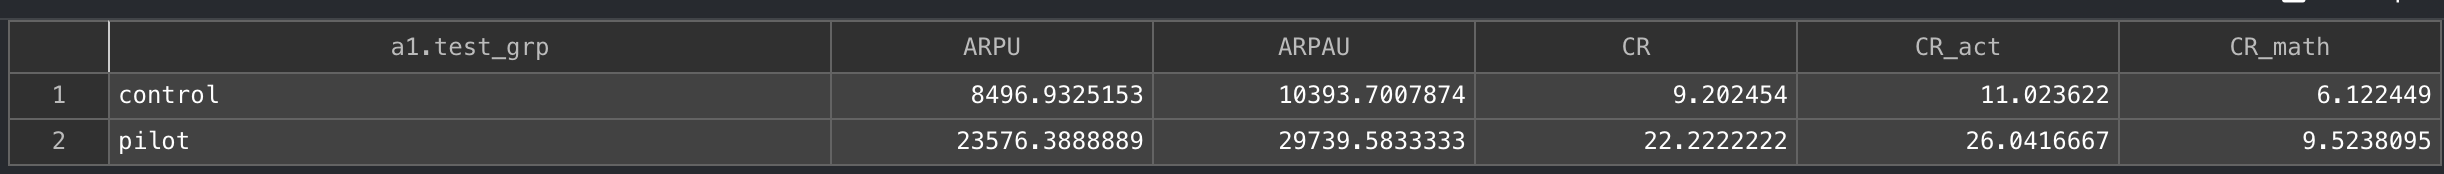